In [8]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Load the training data
train_data = pd.read_csv('data/train.csv')

# Display first few rows to understand the data
train_data.head()

,Sentence_id,Text,Verdict
0,1,I think we've seen a deterioration of values.,-1
1,2,I think for a while as a nation we condoned th...,-1
2,3,"For a while, as I recall, it even seems to me ...",-1
3,4,"So we've seen a deterioration in values, and o...",-1
4,5,"We got away, we got into this feeling that val...",-1


In [6]:
# Split data into features and target
X = train_data['Text']
y = train_data['Verdict']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_val.shape)

Train shape: (18000,) Test shape: (4501,)


In [9]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', MultinomialNB())
])

# Define hyperparameters for grid search
param_grid = {
    'tfidf__max_features': [3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0],  # Smoothing parameter
}

# Perform grid search to find best parameters
print("\nPerforming grid search...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', verbose=1)
grid_search.fit(X_train, y_train)


Performing grid search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000,
                                                        ngram_range=(1, 2))),
                                       ('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.01, 0.1, 0.5, 1.0],
                         'tfidf__max_features': [3000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1_macro', verbose=1)

In [10]:
best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")


Best parameters: {'classifier__alpha': 0.1, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 3)}


In [11]:
# Evaluate on validation set
y_pred = best_model.predict(X_val)

# Calculate metrics
validation_accuracy = accuracy_score(y_val, y_pred)
validation_f1_macro = f1_score(y_val, y_pred, average='macro')
validation_f1_weighted = f1_score(y_val, y_pred, average='weighted')
validation_f1_per_class = f1_score(y_val, y_pred, average=None)

# Print metrics
print("\nValidation set performance:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {validation_accuracy:.4f}")
print(f"Macro F1 Score: {validation_f1_macro:.4f}")
print(f"Weighted F1 Score: {validation_f1_weighted:.4f}")
print(f"F1 Score per class:")
for i, score in enumerate(validation_f1_per_class):
    class_label = {-1: "Not Factual", 0: "Unimportant Fact", 1: "Important Fact"}.get(i-1, f"Class {i-1}")
    print(f"  {class_label}: {score:.4f}")



Validation set performance:
              precision    recall  f1-score   support

          -1       0.79      0.94      0.86      2926
           0       0.55      0.19      0.28       502
           1       0.68      0.55      0.61      1073

    accuracy                           0.76      4501
   macro avg       0.67      0.56      0.58      4501
weighted avg       0.74      0.76      0.73      4501

Accuracy: 0.7605
Macro F1 Score: 0.5815
Weighted F1 Score: 0.7336
F1 Score per class:
  Not Factual: 0.8571
  Unimportant Fact: 0.2772
  Important Fact: 0.6102


Confusion matrix saved as 'confusion_matrix.png'


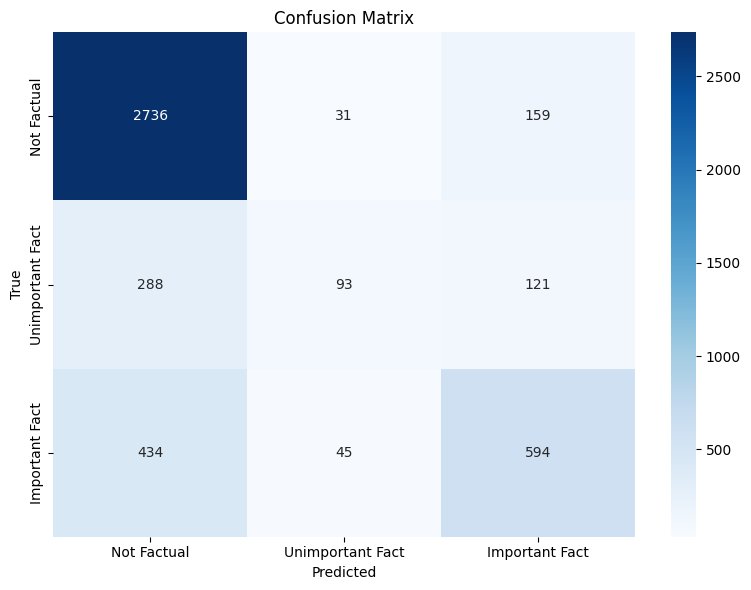

In [12]:
# Create and plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'],
            yticklabels=['Not Factual', 'Unimportant Fact', 'Important Fact'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [13]:
# Train on full training data with best parameters
print("\nTraining final model on all training data...")
best_model.fit(X, y)

# Save the model
joblib.dump(best_model, 'naivebayes_model.pkl')
print("Model saved as 'naivebayes_model.pkl'")


Training final model on all training data...
Model saved as 'naivebayes_model.pkl'


In [14]:
# Function to make predictions on test data
def predict_test_data(model_path, test_path, output_path):
    # Load the model and test data
    model = joblib.load(model_path)
    test_data = pd.read_csv(test_path)
    
    # Make predictions
    predictions = model.predict(test_data['Text'])
    
    # Create output DataFrame
    output_df = pd.DataFrame({
        'Sentence_id': test_data['Sentence_id'],
        'Verdict': predictions
    })
    
    # Save to CSV
    output_df.to_csv(output_path, index=False)
    print(f"Predictions saved to {output_path}")


print("\nMaking predictions on test data...")
predict_test_data('naivebayes_model.pkl', 'data/test.csv', 'data/naivebayes_predictions.csv')


Making predictions on test data...
Predictions saved to data/naivebayes_predictions.csv


kaggle_score = 0.76278

# need to try with balanced classes